Набор данных был скачан с https://www.kaggle.com/c/dogs-vs-cats/data и разархивирован в папку 'train'

In [ ]:
import shutil
import os

data_dir = 'train' 
train_dir = 'set/train' 
val_dir = 'set/val' 
test_dir = 'set/test' 

test_data_portion = 0.15 
val_data_portion = 0.15 

nb_images = 25000
nb_classes = 2
nb_class_images = nb_images // nb_classes

In [ ]:
def create_directory(dir_name):
    if os.path.exists(dir_name):
        shutil.rmtree(dir_name)
    os.makedirs(dir_name)
    os.makedirs(os.path.join(dir_name, "cats"))
    os.makedirs(os.path.join(dir_name, "dogs"))

In [ ]:
# Создаем отдельные директории для обучающей, валидационой и тестоого набора данных 
create_directory(train_dir)
create_directory(val_dir)
create_directory(test_dir)

In [ ]:
def copy_images(start_index, end_index, source_dir, dest_dir):
    for i in range(start_index, end_index):
        shutil.copy2(os.path.join(source_dir, "cat." + str(i) + ".jpg"), os.path.join(dest_dir, "cats"))
        shutil.copy2(os.path.join(source_dir, "dog." + str(i) + ".jpg"), os.path.join(dest_dir, "dogs"))

In [ ]:
# Определение индексов элементов с которых начинается валидационая и тестовая выборки 
start_val_data_idx = int(nb_class_images * (1-val_data_portion-test_data_portion))
start_test_data_idx = int(nb_class_images * (1-test_data_portion))

# Копирование изображений в соответствующие директории
copy_images(0, start_val_data_idx, data_dir, train_dir)
copy_images(start_val_data_idx, start_test_data_idx, data_dir, val_dir)
copy_images(start_test_data_idx, nb_class_images, data_dir, test_dir)

Структура директорий

### Выводим отдельно изображения котов и собак

In [2]:
import matplotlib.pyplot as plt
from tensorflow.python.keras.preprocessing import image

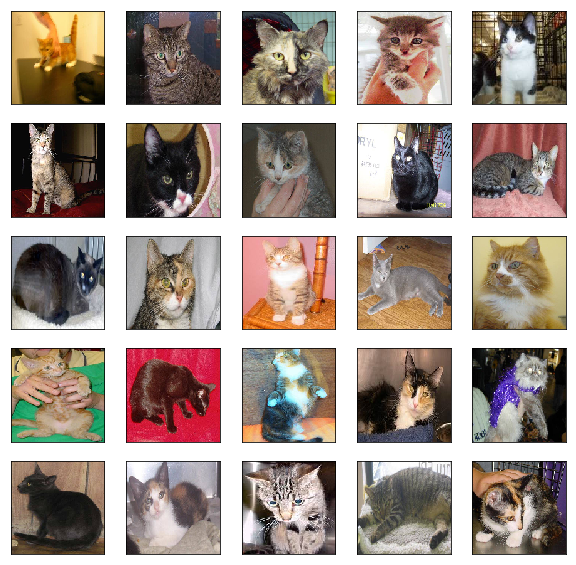

In [5]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image_file_name = data_dir + '/' + os.listdir(data_dir)[i]
    img = image.load_img(image_file_name, target_size=(150, 150))
    plt.imshow(img)
plt.show()

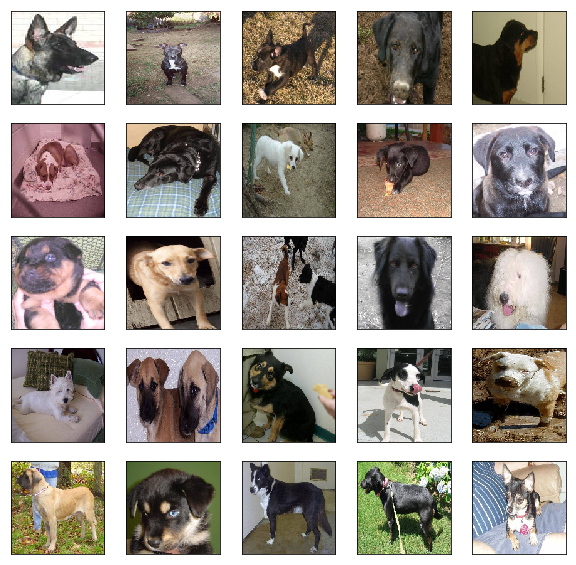

In [6]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image_file_name = data_dir + '/' + os.listdir(data_dir)[-(i+1)]
    img = image.load_img(image_file_name, target_size=(150, 150))
    plt.imshow(img)
plt.show()

### Tranfer Learning using ResNet_V2

In [8]:
from tensorflow import keras
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.applications import resnet_v2

In [10]:
img_width, img_height = 150, 150
input_shape = (img_width, img_height, 3)
epochs = 10
batch_size = 64
nb_train_samples = 17500
nb_validation_samples = 3750
nb_test_samples = 3750

In [18]:
net = resnet_v2.ResNet50V2(weights ='imagenet', include_top = False, input_shape = input_shape)

In [19]:
net.trainable = False

In [40]:
net.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 77, 77, 64)   0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [24]:
datagen = ImageDataGenerator(rescale = 1./255)
train_gen = datagen.flow_from_directory(train_dir, target_size = (img_width, img_height), batch_size = batch_size, class_mode ='binary')
val_gen = datagen.flow_from_directory(val_dir, target_size = (img_width, img_height), batch_size = batch_size, class_mode ='binary')
test_gen = datagen.flow_from_directory(test_dir, target_size = (img_width, img_height), batch_size = batch_size, class_mode ='binary')

Found 17500 images belonging to 2 classes.
Found 3750 images belonging to 2 classes.
Found 3750 images belonging to 2 classes.


In [25]:
model = Sequential()
model.add(net)
model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation = 'sigmoid'))

In [39]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 5, 5, 2048)        23564800  
_________________________________________________________________
flatten_3 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               26214912  
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                

In [26]:
model.compile(optimizer = Adam(), loss ='binary_crossentropy', metrics = ['accuracy'])

In [27]:
model.fit(train_gen, steps_per_epoch = nb_train_samples // batch_size, epochs = 10, validation_data = val_gen, validation_steps = nb_validation_samples // batch_size)

Epoch 1/10
273/273 [==============================] - 494s 2s/step - loss: 0.7934 - accuracy: 0.9343 - val_loss: 0.1133 - val_accuracy: 0.9523
Epoch 2/10
273/273 [==============================] - 483s 2s/step - loss: 0.1461 - accuracy: 0.9599 - val_loss: 0.0825 - val_accuracy: 0.9685
Epoch 3/10
273/273 [==============================] - 488s 2s/step - loss: 0.0892 - accuracy: 0.9708 - val_loss: 0.0811 - val_accuracy: 0.9652
Epoch 4/10
273/273 [==============================] - 487s 2s/step - loss: 0.0641 - accuracy: 0.9798 - val_loss: 0.0872 - val_accuracy: 0.9652
Epoch 5/10
273/273 [==============================] - 499s 2s/step - loss: 0.0496 - accuracy: 0.9851 - val_loss: 0.0943 - val_accuracy: 0.9677
Epoch 6/10
273/273 [==============================] - 484s 2s/step - loss: 0.0403 - accuracy: 0.9879 - val_loss: 0.1172 - val_accuracy: 0.9626
Epoch 7/10
273/273 [==============================] - 480s 2s/step - loss: 0.0357 - accuracy: 0.9884 - val_loss: 0.1055 - val_accuracy: 0.9682

In [28]:
score = model.evaluate(test_gen)
score[1]

59/59 [==============================] - 77s 1s/step - loss: 0.1649 - accuracy: 0.9613


0.9613333344459534

### Тонкая настройка сети

###  Размораживаем последний светрочный блок (conv5)

In [5]:
fine_net = resnet_v2.ResNet50V2(weights ='imagenet', include_top = False, input_shape = input_shape)

In [6]:
for i in fine_net.layers:
    if 'conv5' in i.name:
        i.trainable = True
    else:
        i.trainable = False

In [7]:
fine_net.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 77, 77, 64)   0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [8]:
fine_model = Sequential()
fine_model.add(fine_net)
fine_model.add(Flatten())
fine_model.add(Dense(512, activation = 'relu'))
fine_model.add(Dropout(0.25))
fine_model.add(Dense(256, activation = 'relu'))
fine_model.add(Dropout(0.5))
fine_model.add(Dense(1, activation = 'sigmoid'))

In [9]:
datagen = ImageDataGenerator(rescale = 1./255)
train_gen = datagen.flow_from_directory(train_dir, target_size = (img_width, img_height), batch_size = batch_size, class_mode ='binary')
val_gen = datagen.flow_from_directory(val_dir, target_size = (img_width, img_height), batch_size = batch_size, class_mode ='binary')
test_gen = datagen.flow_from_directory(test_dir, target_size = (img_width, img_height), batch_size = batch_size, class_mode ='binary')

Found 17500 images belonging to 2 classes.
Found 3750 images belonging to 2 classes.
Found 3750 images belonging to 2 classes.


In [10]:
fine_model.compile(optimizer = 'Adam', loss ='binary_crossentropy', metrics = ['accuracy'])

In [11]:
fine_model.fit(train_gen, steps_per_epoch = nb_train_samples // batch_size, epochs = 10, validation_data = val_gen, validation_steps = nb_validation_samples // batch_size)

Epoch 1/10
273/273 [==============================] - 827s 3s/step - loss: 0.2032 - accuracy: 0.9374 - val_loss: 0.1610 - val_accuracy: 0.9529
Epoch 2/10
273/273 [==============================] - 811s 3s/step - loss: 0.0746 - accuracy: 0.9716 - val_loss: 0.1165 - val_accuracy: 0.9612
Epoch 3/10
273/273 [==============================] - 841s 3s/step - loss: 0.0563 - accuracy: 0.9812 - val_loss: 0.1267 - val_accuracy: 0.9631
Epoch 4/10
273/273 [==============================] - 836s 3s/step - loss: 0.0462 - accuracy: 0.9856 - val_loss: 0.1447 - val_accuracy: 0.9639
Epoch 5/10
273/273 [==============================] - 878s 3s/step - loss: 0.0309 - accuracy: 0.9904 - val_loss: 0.1895 - val_accuracy: 0.9666
Epoch 6/10
273/273 [==============================] - 877s 3s/step - loss: 0.0300 - accuracy: 0.9898 - val_loss: 0.2188 - val_accuracy: 0.9539
Epoch 7/10
273/273 [==============================] - 834s 3s/step - loss: 0.0198 - accuracy: 0.9931 - val_loss: 0.1579 - val_accuracy: 0.9642

In [12]:
score = fine_model.evaluate(test_gen)

59/59 [==============================] - 80s 1s/step - loss: 0.1834 - accuracy: 0.9595


### Используем дополнение данных (Data augmentation) для увеличения точности

In [25]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1
)

Исходное изображение 

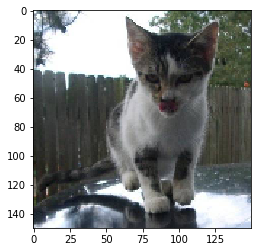

In [23]:
image_file_name = train_dir + '/cats/cat.11.jpg'
img = image.load_img(image_file_name, target_size=(150, 150))
plt.imshow(img)

Выходные изображения

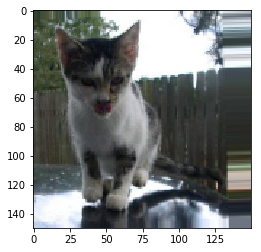

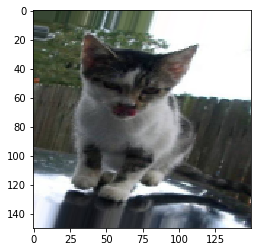

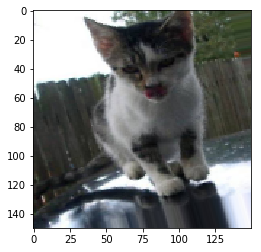

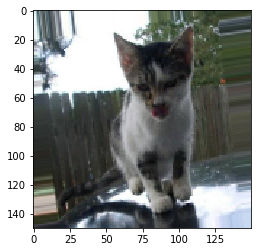

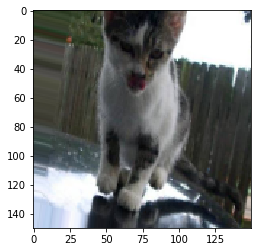

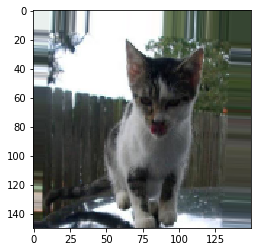

In [27]:
x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)
i = 0
for batch in train_datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 6 == 0:
        break
plt.show()

Построение модели

In [19]:
resnet_data_aug = resnet_v2.ResNet50V2(weights ='imagenet', include_top = False, input_shape =(150, 150, 3))
resnet_data_aug.trainable = False

In [20]:
model_aug = Sequential()
model_aug.add(resnet_data_aug)
model_aug.add(Flatten())
model_aug.add(Dense(256))
model_aug.add(Activation('relu'))
model_aug.add(Dropout(0.5))
model_aug.add(Dense(1))
model_aug.add(Activation('sigmoid'))

In [21]:
model_aug.compile(loss='binary_crossentropy', optimizer= Adam(lr=1e-5), metrics = ['accuracy'])

In [11]:
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(img_width, img_height), batch_size=batch_size, class_mode='binary')

datagen = ImageDataGenerator(rescale = 1./255)
val_generator = datagen.flow_from_directory(val_dir, target_size=(img_width, img_height), batch_size=batch_size, class_mode='binary')
test_generator = datagen.flow_from_directory(test_dir, target_size=(img_width, img_height), batch_size=batch_size, class_mode='binary')

Found 17500 images belonging to 2 classes.
Found 3750 images belonging to 2 classes.
Found 3750 images belonging to 2 classes.


In [23]:
model_aug.fit_generator(train_generator, steps_per_epoch=nb_train_samples // batch_size, epochs = 10, validation_data=val_generator, validation_steps=nb_validation_samples//batch_size)

Epoch 1/10
273/273 [==============================] - 530s 2s/step - loss: 0.3137 - accuracy: 0.9023 - val_loss: 0.1063 - val_accuracy: 0.9617
Epoch 2/10
273/273 [==============================] - 523s 2s/step - loss: 0.1676 - accuracy: 0.9361 - val_loss: 0.0914 - val_accuracy: 0.9617
Epoch 3/10
273/273 [==============================] - 510s 2s/step - loss: 0.1378 - accuracy: 0.9455 - val_loss: 0.0863 - val_accuracy: 0.9639
Epoch 4/10
273/273 [==============================] - 513s 2s/step - loss: 0.1222 - accuracy: 0.9496 - val_loss: 0.0818 - val_accuracy: 0.9636
Epoch 5/10
273/273 [==============================] - 500s 2s/step - loss: 0.1166 - accuracy: 0.9539 - val_loss: 0.0804 - val_accuracy: 0.9658
Epoch 6/10
273/273 [==============================] - 517s 2s/step - loss: 0.1094 - accuracy: 0.9553 - val_loss: 0.0809 - val_accuracy: 0.9677
Epoch 7/10
273/273 [==============================] - 510s 2s/step - loss: 0.1048 - accuracy: 0.9573 - val_loss: 0.0790 - val_accuracy: 0.9652

In [24]:
model_aug.evaluate(test_gen)

59/59 [==============================] - 86s 1s/step - loss: 0.0839 - accuracy: 0.9672


[0.08388065546751022, 0.967199981212616]